In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.head()

,z,hz,err
0,0.0700,69.0,19.6
1,0.0900,69.0,12.0
2,0.1200,68.6,26.2
3,0.1700,83.0,8.0
4,0.1791,75.0,4.0


In [4]:
data

,z,hz,err
0,0.0700,69.0,19.6
1,0.0900,69.0,12.0
2,0.1200,68.6,26.2
3,0.1700,83.0,8.0
4,0.1791,75.0,4.0
5,0.1993,75.0,5.0
6,0.2000,72.9,29.6
7,0.2700,77.0,14.0
8,0.2800,88.8,36.6
9,0.3519,83.0,14.0


Read the data for cosmic chronometers

In [5]:
randomize = np.random.permutation(len(data.values))
randomize


array([11,  3, 22, 13, 25, 12, 21, 20,  4,  2, 26, 19,  6, 27, 29,  0, 24,
       14, 17, 10, 28,  5,  7,  8,  1, 16,  9, 23, 15, 18, 30])

Let's prepare our input data. 

In [6]:
data = data.values[randomize]
data

array([[4.000e-01, 9.500e+01, 1.700e+01],
       [1.700e-01, 8.300e+01, 8.000e+00],
       [8.800e-01, 9.000e+01, 4.000e+01],
       [4.247e-01, 8.710e+01, 1.120e+01],
       [1.300e+00, 1.680e+02, 1.700e+01],
       [4.004e-01, 7.700e+01, 1.020e+01],
       [8.754e-01, 1.250e+02, 1.700e+01],
       [7.812e-01, 1.050e+02, 1.200e+01],
       [1.791e-01, 7.500e+01, 4.000e+00],
       [1.200e-01, 6.860e+01, 2.620e+01],
       [1.363e+00, 1.600e+02, 3.360e+01],
       [6.797e-01, 9.200e+01, 8.000e+00],
       [2.000e-01, 7.290e+01, 2.960e+01],
       [1.430e+00, 1.770e+02, 1.800e+01],
       [1.750e+00, 2.020e+02, 4.000e+01],
       [7.000e-02, 6.900e+01, 1.960e+01],
       [1.037e+00, 1.540e+02, 2.000e+01],
       [4.497e-01, 9.280e+01, 1.290e+01],
       [4.800e-01, 9.700e+01, 6.200e+01],
       [3.802e-01, 8.300e+01, 1.350e+01],
       [1.530e+00, 1.400e+02, 1.400e+01],
       [1.993e-01, 7.500e+01, 5.000e+00],
       [2.700e-01, 7.700e+01, 1.400e+01],
       [2.800e-01, 8.880e+01, 3.66

In [7]:
X = data[:,0]
y = data[:,1:]
X.shape, y.shape

((31,), (31, 2))

In [8]:
split = 0.8
ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
y_train, y_test = np.split(y, indx)
X_train, y_train

(array([0.4   , 0.17  , 0.88  , 0.4247, 1.3   , 0.4004, 0.8754, 0.7812,
        0.1791, 0.12  , 1.363 , 0.6797, 0.2   , 1.43  , 1.75  , 0.07  ,
        1.037 , 0.4497, 0.48  , 0.3802, 1.53  , 0.1993, 0.27  , 0.28  ]),
 array([[ 95. ,  17. ],
        [ 83. ,   8. ],
        [ 90. ,  40. ],
        [ 87.1,  11.2],
        [168. ,  17. ],
        [ 77. ,  10.2],
        [125. ,  17. ],
        [105. ,  12. ],
        [ 75. ,   4. ],
        [ 68.6,  26.2],
        [160. ,  33.6],
        [ 92. ,   8. ],
        [ 72.9,  29.6],
        [177. ,  18. ],
        [202. ,  40. ],
        [ 69. ,  19.6],
        [154. ,  20. ],
        [ 92.8,  12.9],
        [ 97. ,  62. ],
        [ 83. ,  13.5],
        [140. ,  14. ],
        [ 75. ,   5. ],
        [ 77. ,  14. ],
        [ 88.8,  36.6]]))

In [9]:
# scaler = StandardScaler()
# # scaler = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scaler.fit(X.reshape(-1,1))
# # apply transform
# X = scaler.transform(X.reshape(-1,1))
# X

In [10]:
def autoencoder(input_z):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(500, activation='relu')(efirst)
    elast = Dense(50, activation='linear')(ehidden)
    
    #decoder 
    dfirst = Dense(50, activation='linear')(elast)
    dhidden = Dense(500, activation='relu')(dfirst)
    dlast = Dense(100, activation='relu')(dhidden)
    decoded = Dense(2, activation='relu')(dlast)
    
    return decoded

In [11]:
batch_size = 2
epochs = 100
input_z = Input(shape = (1,))

In [12]:
autoencoder = Model(input_z, autoencoder(input_z))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [13]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               50100     
__________

In [14]:
autoencoder_train = autoencoder.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Train on 24 samples, validate on 7 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
24/24 [==============================] - 0s 15ms/sample - loss: 6564.0943 - val_loss: 6015.5366
Epoch 2/100
24/24 [==============================] - 0s 1ms/sample - loss: 4807.6978 - val_loss: 1434.8132
Epoch 3/100
24/24 [==============================] - 0s 1ms/sample - loss: 961.4705 - val_loss: 368.4317
Epoch 4/100
24/24 [==============================] - 0s 1ms/sample - loss: 319.3550 - val_loss: 294.1834
Epoch 5/100
24/24 [==============================] - 0s 1ms/sample - loss: 299.0398 - val_loss: 360.9535
Epoch 6/100
24/24 [==============================] - 0s 1ms/sample - loss: 289.2180 - val_loss: 199.5542
Epoch 7/100
24/24 [==============================] - 0s 1ms/sample - loss: 259.2926 - val_loss: 215.2954
Epoch 8/100
24/24 [==============================] - 0s 1ms/sample - loss: 236.8154 - val_loss: 182.1806
Epoch 9/100
24/24 [==============================] - 0s 1ms/samp

24/24 [==============================] - 0s 1ms/sample - loss: 191.7925 - val_loss: 165.9607
Epoch 76/100
24/24 [==============================] - 0s 1ms/sample - loss: 191.3134 - val_loss: 135.2192
Epoch 77/100
24/24 [==============================] - 0s 1ms/sample - loss: 177.4406 - val_loss: 137.1807
Epoch 78/100
24/24 [==============================] - 0s 1ms/sample - loss: 207.3327 - val_loss: 122.8099
Epoch 79/100
24/24 [==============================] - 0s 1ms/sample - loss: 278.7245 - val_loss: 423.7538
Epoch 80/100
24/24 [==============================] - ETA: 0s - loss: 150.646 - 0s 1ms/sample - loss: 187.5628 - val_loss: 122.3464
Epoch 81/100
24/24 [==============================] - 0s 1ms/sample - loss: 242.5202 - val_loss: 110.6406
Epoch 82/100
24/24 [==============================] - 0s 1ms/sample - loss: 192.7254 - val_loss: 132.4238
Epoch 83/100
24/24 [==============================] - 0s 1ms/sample - loss: 198.2645 - val_loss: 113.8064
Epoch 84/100
24/24 [=============

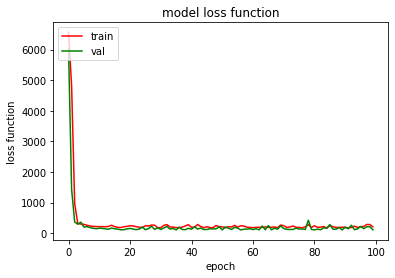

In [53]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
plt.title('model loss function')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_ae.png")

In [16]:
pred = autoencoder.predict(X_test)
pred.shape

(7, 2)

In [17]:
pred

array([[ 65.9212  ,  12.758515],
       [ 88.74312 ,  16.865698],
       [ 81.31409 ,  15.528726],
       [115.596565,  21.717867],
       [ 88.255295,  16.777914],
       [ 95.47863 ,  18.077871],
       [189.55676 ,  35.134045]], dtype=float32)

In [65]:
r = np.random.uniform(0, 2.2, size=10000)
# r_inv = scaler.inverse_transform(r)
# X = scaler.inverse_transform(X)
# X

In [66]:
pred_random = autoencoder.predict(r)
pred_random

array([[ 79.151924,  15.139606],
       [152.78621 ,  28.46412 ],
       [112.529724,  21.161535],
       ...,
       [177.68538 ,  32.980656],
       [ 89.57214 ,  17.014902],
       [159.25194 ,  29.636957]], dtype=float32)

(0.0, 2.2)

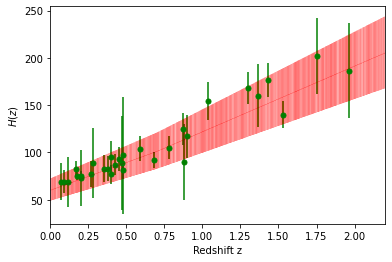

In [67]:
# plt.scatter(data[:, 0], data[:, 1], c='g')
yupp = pred_random[:,0]+pred_random[:,1]
ylow = pred_random[:,0]-pred_random[:,1]
plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic', alpha=0.006)
# y1 = plt.plot(r, yupp, c='b')
# y2 = plt.plot(r, ylow, c='k')
# plt.fill_between(r, yupp, ylow, where=yupp>ylow, facecolor='y')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0,2.2)

0.07